# Galaxy redshift distributions

Simulating continuous redshift distributions from a pre-constructed set of density or lensing shells (be it GLASS or other simulations) comes with an important caveat: the two-point (and higher-order) statistics are **fixed by the shells**, no matter what redshifts are ultimately assigned to the galaxies.

Within a particular shell, the individual galaxy redshifts are effectively dummy variables. The clustering and lensing signals are fully determined by the definition of the shell (and these internal redshifts have no impact).

This example notebook shows how the choice of matter shells fully determines the final redshift distribution of galaxies, and how this affects galaxy clustering and lensing.

First, a number of required imports.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import glass

We will require a cosmology object below. Here, we construct an arbitrary cosmology from CAMB.

In [ ]:
# arbitrary example cosmology from CAMB
import camb
import camb.sources
from cosmology import Cosmology

import glass.ext.camb

lmax = 200

# basic cosmology
pars = camb.set_params(
    H0=70.0,
    omch2=0.25 * 0.7**2,
    ombh2=0.05 * 0.7**2,
)

# get cosmology object for GLASS
cosmo = Cosmology.from_camb(pars)

For this example, we want to simulate a normal-looking redshift distribution such as the following.

In [ ]:
z = np.arange(0.0, 5.0, 0.01)
nz = glass.smail_nz(z, 1.0, 1.5, 2.0)

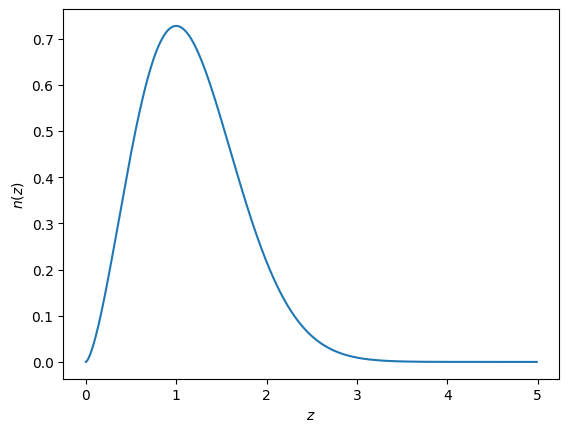

In [ ]:
plt.plot(z, nz)
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.show()

## Simulation setup

For the simulation (GLASS or otherwise), we have a given set of redshift shells. Here, we use a comoving distance grid as an arbitrary example.

In [ ]:
zgrid = glass.distance_grid(cosmo, 0.0, 3.5, num=20)

We then have to set the radial profile of the shells. Here, we use a tophat profile in redshift as our first example. Later, we will see how this impacts the results.

In [ ]:
shells = glass.tophat_windows(zgrid)

These are all the ingredients that define the radial discretisation of the simulation. For a GLASS simulation, these are usually user choices; for *N*-body simulations, they might instead be given.

## Matching the redshift distribution

With the (matter or lensing) shells defined, the clustering or lensing of each sampled galaxy is fully determined by its associated shell. The only choice is *how many* galaxies are assigned to each shell: having relatively more galaxies in a specific shell will make the clustering or lensing signal from that shell become more prominent in the final galaxy sample.

**The clustering and lensing signals are fully determined by how many galaxies end up in each shell.**

We expect that if we assign galaxies to shells according to their desired $n(z)$, we will recover the clustering and lensing signals to the best of our abilities.

Fortunately, we can predict exactly how this happens, at least for linear galaxy bias.

In GLASS, we can use the `glass.partition()` function to match a given $n(z)$ to the radial profile of shells. For tophat shells, this is trivial; for other shells, it requires techniques such a non-negative least squares solver.

In [ ]:
ngal = glass.partition(z, nz, shells)

In [ ]:
# the result of splitting the n(z) up over shells
ngal

array([0.00125538, 0.00564149, 0.01252906, 0.02165866, 0.03282337,
       0.04573353, 0.05985262, 0.07430384, 0.087862  , 0.09896062,
       0.10572553, 0.10658204, 0.1004076 , 0.08627026, 0.06721855,
       0.04606434, 0.02695859, 0.0130401 , 0.0051696 , 0.00194282])

It bears repeating: after the shells are fixed, this relative distribution of galaxies over shells is the only remaining degree of freedom. Within each shell, the clustering and lensing signal is given by radial profile of the shell itself. The relative galaxy numbers `ngal` say how we combine this signal; the true $n(z)$ is hence the sum of the radial profiles of the shell, weighted by `ngal`.

Using the function `glass.combine()` we can produce the effective $n(z)$ of our simulation, given a set of shell and their relative weights.

In [ ]:
nz_eff = glass.combine(z, ngal, shells)

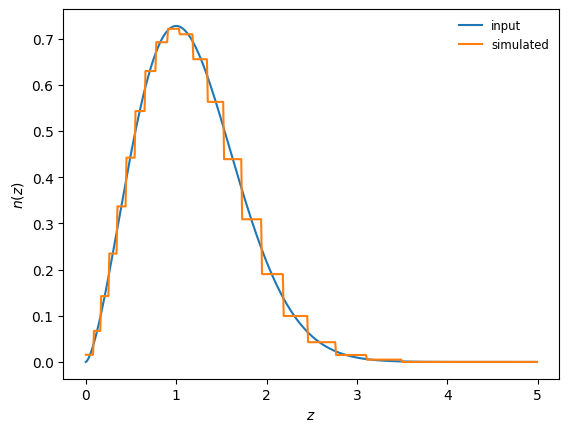

In [ ]:
# show input n(z) and effective output of the simulation
plt.plot(z, nz, label="input")
plt.plot(z, nz_eff, label="simulated")
plt.legend()
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.show()

Given a fixed set of shells, this is really the "best" (or at least close) effective $n(z)$ that we can sample.

## Effective clustering and lensing

Similar to the above, we can also compute the expected galaxy clustering and lensing signals: if all we do is put more of fewer galaxies into each shell, their combined signals are a linear combination of the signals of the shells.

To demonstrate this, we must first compute the spectra of the shells.

In [ ]:
# compute angular matter power spectra with CAMB
spectra = glass.ext.camb.matter_cls(pars, lmax, shells)

To compute the effective clustering spectra for `ngal` galaxies in each shell, we can use the `glass.effective_cls()` function.

In [ ]:
clustering_weights = glass.position_weights(ngal, bias=1.0)
clustering = glass.effective_cls(spectra, clustering_weights)

Lensing is a non-local effect that happens along the line of sight between a galaxy and the observer. Therefore, we must first convert the weights `ngal` into a set of "lensing weights" that take this line-of-sight effect into account.

How the lensing is computed is fully determined by the shell definition in GLASS. However, there *is* an additional degree of freedom here; namely, the effective redshift of each shell (see the GLASS paper for more details).

In [ ]:
lensing_weights = glass.multi_plane_weights(ngal, shells, cosmo)

In [ ]:
# lensing weights are an array of numbers much like ngal
lensing_weights

array([1.40172249e-03, 3.96236548e-03, 6.14957033e-03, 7.88046658e-03,
       9.09531217e-03, 9.76151090e-03, 9.87782571e-03, 9.47783631e-03,
       8.63145114e-03, 7.44327196e-03, 6.04631012e-03, 4.58919454e-03,
       3.21865123e-03, 2.05760198e-03, 1.17603535e-03, 5.87348431e-04,
       2.49054028e-04, 8.57266333e-05, 2.05607448e-05, 0.00000000e+00])

In [ ]:
# compute the lensing signal from the lensing weights
lensing = glass.effective_cls(spectra, lensing_weights)

Having both the clustering and lensing weights, we can also compute the cross-correlation between clustering and lensing (galaxy-galaxy lensing) by providing both sets of weights.

In [ ]:
cross = glass.effective_cls(spectra, ngal, lensing_weights)

At this point, we can **predict exactly what our simulated signals will look like**, without running a simulation at all.

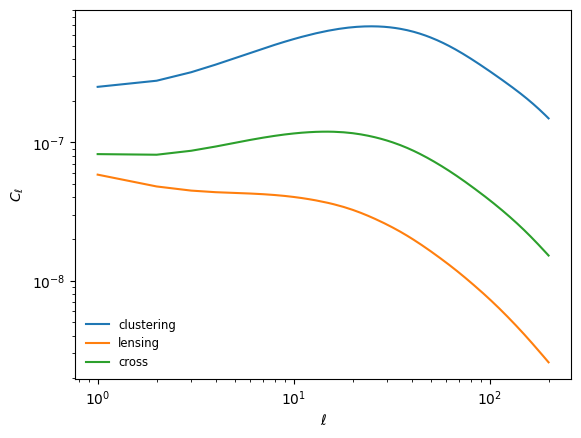

In [ ]:
# show the expected galaxy spectrum from the simulation
ell = np.arange(lmax + 1)
plt.plot(ell[1:], clustering[1:], label="clustering")
plt.plot(ell[1:], lensing[1:], label="lensing")
plt.plot(ell[1:], cross[1:], label="cross")
plt.legend(loc="lower left")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell$")
plt.show()

Finally, we can compare this with the expected signal from theory using the **original** $n(z)$.

In [ ]:
# boost accuracy for power spectrum computation
pars.Accuracy.TimeStepBoost = 5

# no effects on top of clustering for demonstration
pars.SourceTerms.counts_density = True
pars.SourceTerms.counts_redshift = False
pars.SourceTerms.counts_lensing = False
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_radial = False
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

# angular scales
pars.min_l = 1
pars.set_for_lmax(lmax)

# use the _original_ n(z) for theory
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=nz, source_type="counts"),
    camb.sources.SplinedSourceWindow(z=z, W=nz, source_type="lensing"),
]

# compute theory spectra
theory = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

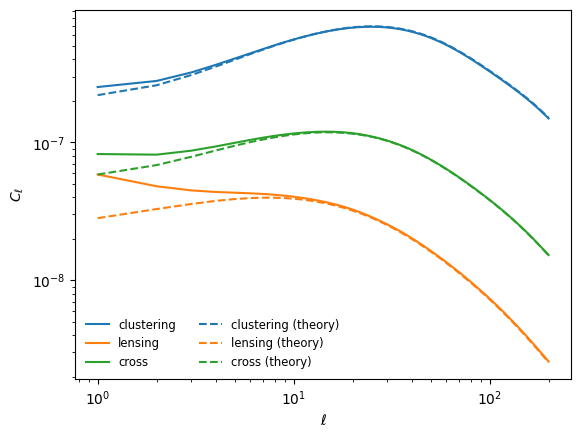

In [ ]:
# show the expected galaxy spectrum from the simulation
# overplot the theory using the original n(z)
ell = np.arange(lmax + 1)
plt.plot(ell[1:], clustering[1:], label="clustering")
plt.plot(ell[1:], lensing[1:], label="lensing")
plt.plot(ell[1:], cross[1:], label="cross")
plt.plot(ell[1:], theory["W1xW1"][1:], label="clustering (theory)", c="C0", ls="--")
plt.plot(ell[1:], theory["W2xW2"][1:], label="lensing (theory)", c="C1", ls="--")
plt.plot(ell[1:], theory["W1xW2"][1:], label="cross (theory)", c="C2", ls="--")
plt.legend(loc="lower left", ncols=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell$")
plt.show()

For an in-depth explanation of these differences at large scales, please refer to the GLASS paper.

## Linear windows

We have seen that the quality of our simulated galaxy redshift distribution is closely tied to how well we can match the individual radial profiles of the shells to our desired $n(z)$. For tophat windows, as used above, it is clear that this match will never be close unless the shells are very thin compared to the width of the $n(z)$.

An alternative is the linear window function available as `glass.linear_windows()`, which is an overlapping triangular profile.

In [ ]:
shells_lin = glass.linear_windows(zgrid)

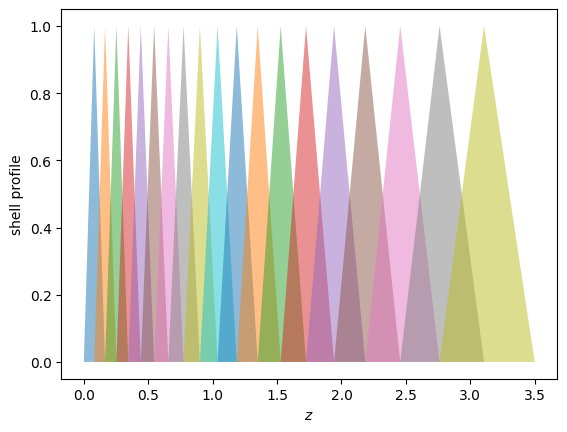

In [ ]:
# show the linear windows
for shell in shells_lin:
    plt.fill(shell.za, shell.wa, alpha=0.5)
plt.xlabel("$z$")
plt.ylabel("shell profile")
plt.show()

The reason for this choice is simple: if tophat windows correspond to nearest-neighbour interpolation of the desired galaxy $n(z)$, linear windows correspond to linear interpolation, which greatly improves the quality of the effective $n(z)$.

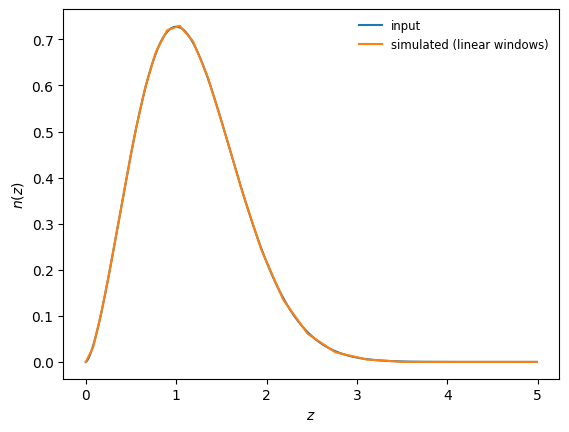

In [ ]:
ngal_lin = glass.partition(z, nz, shells_lin)
nz_eff_lin = glass.combine(z, ngal_lin, shells_lin)

# show input n(z) and effective output of the simulation
plt.plot(z, nz, label="input")
plt.plot(z, nz_eff_lin, label="simulated (linear windows)")
plt.legend()
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.show()

Recomputing all weights, we similarly find a much better agreement with theory.

In [ ]:
# lensing weights for linear windows
lensing_weights_lin = glass.multi_plane_weights(ngal_lin, shells_lin, cosmo)

# recompute the matter power spectra of the shells for linear windows
spectra_lin = glass.ext.camb.matter_cls(pars, lmax, shells_lin)

# compute the observed spectra from the weights
clustering_lin = glass.effective_cls(spectra_lin, ngal_lin)
lensing_lin = glass.effective_cls(spectra_lin, lensing_weights_lin)
cross_lin = glass.effective_cls(spectra_lin, ngal_lin, lensing_weights_lin)

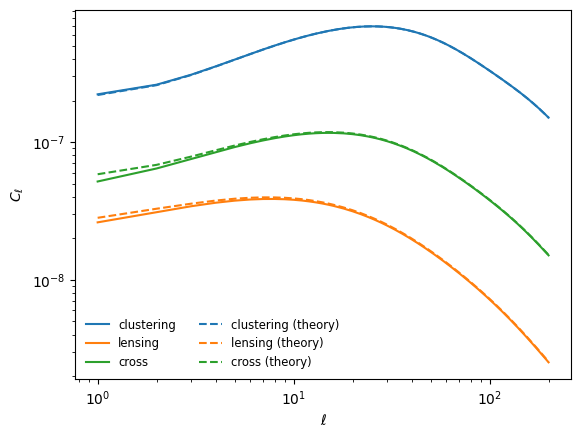

In [ ]:
# show the expected galaxy spectrum from the simulation using linear windows
# overplot the theory using the original n(z)
ell = np.arange(lmax + 1)
plt.plot(ell[1:], clustering_lin[1:], label="clustering")
plt.plot(ell[1:], lensing_lin[1:], label="lensing")
plt.plot(ell[1:], cross_lin[1:], label="cross")
plt.plot(ell[1:], theory["W1xW1"][1:], label="clustering (theory)", c="C0", ls="--")
plt.plot(ell[1:], theory["W2xW2"][1:], label="lensing (theory)", c="C1", ls="--")
plt.plot(ell[1:], theory["W1xW2"][1:], label="cross (theory)", c="C2", ls="--")
plt.legend(loc="lower left", ncols=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell$")
plt.show()

All in all, using linear window functions is therefore a simple way to greatly improve the quality of a simulation, and is our recommended default for GLASS.